# Submission 3

Joe Hoong Ng (ng_joehoong@hotmail.com)

Dang Duy Nghia Nguyen (nghia002@e.ntu.edu.sg)

Dylan Thorne (dylan.thorne@gmail.com)

Zain Us Sami Ahmed Ansari (zainussami@gmail.com)	



In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import scipy.optimize

import math
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1 
Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and
counterparty firm values. You should simulate the values monthly, and should have LIBOR
forward rates applying over one month, starting one month apart, up to maturity. You may
assume that the counterparty firm and stock values are uncorrelated with LIBOR forward
rates

In [2]:
### Initialize problem parameters
T = 1 # option maturity
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money


v_0 = 200 # counterparty firm current value
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
########

corr_matrix = np.array([[1, corr], [corr, 1]])
sample_size = 100000

In [3]:
sigma_const = 0.30
gamma = 0.75

## Calibrate LIBOR forward rate model from zero coupon bond prices

In [4]:
t = np.linspace(0,1,13)

market_zcb_prices = np.array([1.0, 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516,
       0.9457, 0.9399, 0.9342, 0.9285])



In [5]:
def A(t1, t2, alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha
def D(t1, t2, alpha, b, sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1-val2

def bond_price_fun(r,t,T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r+D(t,T,alpha,b,sigma))

#r0 = 0.05

def F(x):
    alpha = x[0]
    b = x[1]
    sigma = x[2]
    r0 = x[3]
    return sum(np.abs(bond_price_fun(r0,0,t,alpha,b,sigma)-market_zcb_prices))

In [6]:
#minimizing F
bnds = ((0,1),(0,0.2),(0,0.2), (0.00,0.10))
opt_val = scipy.optimize.fmin_slsqp(F, (0.3, 0.05, 0.03, 0.05), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sig = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00025649906704716674
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10


In [7]:
print("Optimal alpha: {:.3f}".format(opt_val[0]))
print("Optimal b: {:.3f}".format(opt_val[1]))
print("Optimal sig: {:.3f}".format(opt_val[2]))
print("Optimal r0: {:.3f}".format(opt_val[3]))

Optimal alpha: 0.273
Optimal b: 0.069
Optimal sig: 0.028
Optimal r0: 0.075


C:\Users\ng_jo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


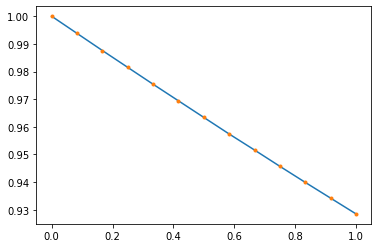

In [8]:
model_prices = bond_price_fun(opt_r0,0,t, opt_alpha, opt_b, opt_sig)
model_yield = -np.log(model_prices)/t

plt.plot(t,market_zcb_prices)
plt.plot(t, model_prices, '.')
plt.show()


## Simulate LIBOR rate paths 

In [9]:
def vasi_mean(r, t1, t2):
    return np.exp(-opt_alpha*(t2-t1))*r+opt_b*(1-np.exp(-opt_alpha*(t2-t1)))

def vasi_var(t1,t2):
    return (opt_sig**2)*(1-np.exp(-2*opt_alpha*(t2-t1)))/(2*opt_alpha)

In [10]:
Z = norm.rvs(size = [sample_size, 13])
r_sim = np.zeros([sample_size, 13])
r_sim[:, 0] = opt_r0
vasi_mean_vector = np.zeros(13)

for i in range(12):
    r_sim[:, i+1] = vasi_mean(r_sim[:, i], t[i], t[i+1]) + np.sqrt(vasi_var(t[i], t[i+1]))*Z[:, i]
    
s_mean = opt_r0*np.exp(-opt_alpha*t)+opt_b*(1-np.exp(-opt_alpha*t))

In [11]:
s_mean

array([0.07498906, 0.07486278, 0.07473934, 0.07461868, 0.07450074,
       0.07438546, 0.07427277, 0.07416263, 0.07405496, 0.07394972,
       0.07384685, 0.0737463 , 0.07364801])

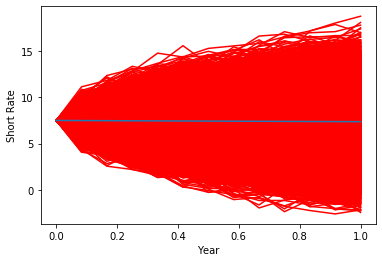

In [12]:
t_graph = np.ones(r_sim.shape)*t
plt.plot(np.transpose(t_graph), np.transpose(r_sim*100), 'r')
plt.plot(t, s_mean*100)
plt.xlabel("Year")
plt.ylabel("Short Rate")
plt.show()


The LIBOR forward rates are:

In [13]:
r_sim

array([[0.07498906, 0.06591623, 0.06395513, ..., 0.05027965, 0.03404807,
        0.02389856],
       [0.07498906, 0.06921908, 0.06451249, ..., 0.04592139, 0.03836549,
        0.04852935],
       [0.07498906, 0.07704236, 0.08395671, ..., 0.08570294, 0.07336188,
        0.08467704],
       ...,
       [0.07498906, 0.08208588, 0.08617566, ..., 0.07510159, 0.07121121,
        0.04970869],
       [0.07498906, 0.07284746, 0.06428927, ..., 0.05833484, 0.05361982,
        0.05633438],
       [0.07498906, 0.07866863, 0.0893057 , ..., 0.07927864, 0.08573241,
        0.08439109]])

## Generate stock and firm values

In [14]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, Z, varying_vol = True):

    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)

    return prev_price*np.exp((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z)



In [15]:


def generate_share_and_firm_price(S0, v_0, r_sim, sigma_const, gamma, corr, T, sample_size, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    
    share_price_path = pd.DataFrame(next_share_price(S0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,0,]))
    share_price_path = share_price_path.transpose()
    
    first_row = pd.DataFrame([S0]*sample_size)
    first_row = first_row.transpose()
    share_price_path = pd.concat([first_row, share_price_path])

    firm_price_path = pd.DataFrame(next_share_price(v_0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,1,]))
    firm_price_path = firm_price_path.transpose()
    
    first_row = pd.DataFrame([v_0]*sample_size)
    first_row = first_row.transpose()
    firm_price_path = pd.concat([first_row, firm_price_path])

    return [share_price_path,firm_price_path]  

In [16]:

share_prices, firm_prices = generate_share_and_firm_price(S0, v_0, r_sim[:,1:], sigma_const, gamma, corr, T, sample_size, timesteps = 12)

In [17]:
share_prices

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0,95.415877,99.819377,97.781417,102.689253,103.520604,100.357391,100.511429,95.980262,102.087242,97.397063,...,103.380159,102.115127,104.033291,101.342812,98.565522,102.385767,103.574157,98.235956,95.451643,99.563260
1,98.673676,100.676082,100.237915,105.550231,99.206633,99.622877,100.421900,101.466208,104.943055,103.167104,...,97.615937,101.853288,97.303189,101.426811,101.853870,101.424997,97.980724,103.723017,99.532095,105.462681
2,103.327300,98.715427,98.993167,104.155334,99.415548,100.070829,102.652916,99.343556,101.334967,100.456847,...,98.103852,96.614422,101.795867,102.116081,100.651610,92.995265,101.591465,99.808030,98.069512,103.360153
3,98.841063,99.059786,100.335244,104.833297,99.405199,98.845573,102.471480,101.698603,100.035398,100.591456,...,99.730427,100.116514,102.744343,104.839832,104.186256,100.621041,109.240494,98.089028,97.458122,101.968621
4,97.456095,102.146672,99.723473,99.742528,100.535134,102.235131,98.932579,103.336381,93.757010,101.127966,...,97.062772,103.243386,99.783079,98.772177,100.924374,97.337294,100.057736,101.267832,104.238420,103.334339
5,103.438647,103.916573,103.528943,98.422791,103.233822,104.400370,101.761148,101.832148,102.257238,99.968719,...,98.774691,102.839064,99.513581,106.390784,104.245880,99.212410,103.691355,103.247802,103.083265,99.981577
6,98.228755,100.055127,100.117982,105.068536,102.347025,102.572823,98.670701,102.817768,103.090521,104.605635,...,103.055516,102.517593,98.516012,102.356029,100.415025,105.149505,98.785895,100.188674,99.289662,98.607953
7,97.168025,97.408877,95.810526,103.022338,99.990565,99.982856,99.616429,105.000378,103.668702,99.827927,...,100.671349,99.917005,101.707912,100.268153,103.722534,100.662767,100.961518,106.628311,103.684424,101.449704
8,104.269273,100.729226,97.523602,93.621297,99.786733,104.852730,97.010804,96.729340,96.781454,101.370150,...,104.026400,97.534396,99.336311,101.865016,98.811141,102.337016,100.550463,98.176639,101.880732,103.464167


In [18]:
firm_prices

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
0,206.030257,199.779427,198.612963,199.919356,198.360543,204.005315,203.688958,200.436165,194.560522,204.374909,...,200.749449,206.498703,200.940745,203.602585,201.574621,209.116855,208.409712,193.434358,206.667013,201.298723
1,196.951397,198.440566,207.761106,203.830176,196.747626,204.118429,193.135778,202.464279,201.607084,198.626504,...,212.143987,197.957703,195.299816,203.250667,200.542343,192.425114,192.954545,206.797401,200.770222,209.908765
2,204.898957,195.169426,202.915019,196.413077,205.449631,200.737300,210.050915,200.671084,204.213601,196.798682,...,193.387624,195.399189,206.813140,190.875947,204.413055,198.179265,200.727326,198.644348,204.733463,206.569597
3,204.725733,203.372855,198.810040,201.997644,209.069514,194.882440,199.496365,202.211450,206.489844,196.295108,...,198.197366,201.777899,201.873192,206.987498,204.659952,202.794525,203.620385,198.370084,202.060011,202.710946
4,203.123340,206.353520,204.226316,207.561620,195.995758,202.870933,202.621519,199.094191,203.465843,201.315627,...,196.497839,207.269592,193.316395,203.481105,196.829545,197.381919,206.818770,199.759213,194.165049,203.423895
5,195.205353,208.882969,196.024172,200.925584,202.043755,198.432415,195.813781,197.927012,198.328530,199.950627,...,203.334791,204.619309,198.794415,193.230548,204.556313,199.215456,201.836264,199.358756,208.358717,197.303360
6,195.892102,197.157981,203.372117,199.743127,201.002415,198.203760,198.698136,196.084566,205.264841,204.988581,...,198.568416,199.184941,205.386912,205.287713,198.264741,202.588562,207.920265,199.398477,202.555746,200.088945
7,196.201654,193.453580,201.097296,193.742740,195.133958,198.933054,200.443646,202.488222,209.588269,199.727039,...,197.157333,199.128317,193.450455,216.208182,200.880241,205.915885,202.239033,203.229040,198.317996,203.990539
8,206.249205,200.641389,207.882550,198.858636,200.402823,207.319536,198.348920,196.718243,201.637507,192.385356,...,193.965986,199.690018,196.994255,210.694191,208.034747,195.228550,194.855351,197.418473,204.854957,203.182599
